# New collaborations are driven by research trends

## Brief overview

We assume that a new collaboration might be initiated due to research trends. For example, in 2022 the percentage on LLMs out of all computer science and statistics papers jumped from 7.5% to 15% in 2023 following the release of ChatGPT. A lot of researchers decided to jump on this trend, hence we assume following research trend peaks may also be one of the possible reasons to start a new collaboration. 

To test this hypothesis, we will want to evaluate whether (proportionally) more new collaborations occur in trending research areas versus non-trending research areas. To do this, we will first need to evaluate keywords for all articles, which we will do by prompting the `Llama-3.1-8B` model. Then we will fetch keyword trends by querying the number of articles yearly via Crossref API. The number of articles will be normalized by the number of articles in the related research area in a given year so that we will not identify seemingly large growth just because the number of articles in general follows the "publish or perish" dogma.

This data will allow us to determine whether a publication $p$ was published in **peaking attention** or **balanced attention** years. Given a keyword $k$ for article $p$, we define keyword trend as $T_k$, which contains a value for each year from (and including) 2000 on. Next, we want to tag articles for which we assume happened in the trending, popular years. To quantify this, we will first define the peaking attention years as $T_{k+}$ and the balanced attention years as $T_{k-}$, where we:
- transform all time series to year-over-year and then calculate the 3-year rolling average: $f(x)=rolling\_avg(yoy(x), 3)$,
- define the target variable $y_k$ counting the publications for a given keyword $k$,
- define the baseline on research area $r_k$ , given a keyword $k$, granularity as the median publication count of all keyword trends for the given research area: $baseline(t, r_k) = median(\{y_k(t); t \in T_k, k \in K(r_k)\})$, where $K(r_k)$ is the set of all keywords attributed to the given research area,
- define the threshold $\Theta$ that allows us to set the sensitivity of classifying a year as a *peaking attention year*.

Then, we can define peaking attention years and balanced attention years as follows:
- $T_{k+}=\{t \in T_k; f(y(t)) > f(baseline(t,r_k)) + \Theta\}$
- $T_{k-}=\{t \in T_k; f(y(t)) <= f(baseline(t,r_k)) + \Theta\}$

Having defined this, we can now classify articles either as collaborations occurring in peaking attention years versus not. We separate the set of articles $P$ to $P_+$ for articles published in peaking attention years and $P_-$ for articles published in balanced attention years. 

For each article, we generated 5 keywords and, given these keywords, we derived a proxy for article keyword popularity by counting how many keywords were in peaking attention years when article $p$ was published. Additionally, we derive the popularity index metric that sums up the differences between the baseline trend and the keyword trend. Using these popularity proxies, we test the correlation between popularity and collaboration novelty by building a linear model.

**Key takeaways:** as we already know, research trends are not the only factor driving new collaborations nor are they guaranteed to be the most vital one. Nonetheless given the test executed below, we can say that research trends play an important role when new collaborations are being formed.

## Imports & global variables

In [1]:
import sys
import os

sys.path.insert(0, os.path.abspath(".."))

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import pandas as pd

from box import Box
from util.postgres import create_sqlalchemy_connection, query

In [2]:
# -------------------- GLOBAL VARIABLES --------------------
PATH_TO_CONFIG_FILE = '../config.yaml'

# -------------------- LOAD CONFIGURATION --------------------
# Load the configuration file
config = Box.from_yaml(filename=PATH_TO_CONFIG_FILE)
# Initialize a BigQuery client
pg_connection = create_sqlalchemy_connection(
    username=config.POSTGRES.USERNAME,
    password=config.POSTGRES.PASSWORD,
    host=config.POSTGRES.HOST,
    port=config.POSTGRES.PORT,
    database=config.POSTGRES.DATABASE,
    schema=config.POSTGRES.SCHEMA
)
sns.set_theme(style="whitegrid", palette="pastel")

## Querying the data

In [3]:
sql_query = """
SELECT *
FROM fct_article_keyword_trend
"""

df = query(conn=pg_connection, query_str=sql_query)
df.head(5)

,article_keyword,research_area_code,article_publication_year,publication_count,publication_normalized_count,publication_count_yoy,publication_count_yoy_3yr_rolling_avg,publication_count_baseline,publication_normalized_count_baseline,publication_count_yoy_baseline,publication_count_yoy_3yr_rolling_avg_baseline,publication_count_yoy_3yr_rolling_avg_diff,publication_count_yoy_3yr_rolling_avg_diff_pct,is_trend_positive
0,#nossavons,S265,2000,0,0.0,NaN,NaN,5165.0,647.0,-0.000679,-0.000679,NaN,NaN,False
1,#nossavons,S265,2001,0,0.0,NaN,NaN,5273.0,659.0,0.043001,0.042893,NaN,NaN,False
2,#nossavons,S265,2002,0,0.0,NaN,NaN,5861.0,730.0,0.064725,0.062500,NaN,NaN,False
3,#nossavons,S265,2003,0,0.0,NaN,NaN,6434.0,799.0,0.065171,0.066657,NaN,NaN,False
4,#nossavons,S265,2004,0,0.0,NaN,NaN,7016.0,868.0,0.086903,0.077811,NaN,NaN,False


In [4]:
sql_query = """
SELECT *
FROM fct_article_by_keyword_popularity
"""

df_popularity = query(conn=pg_connection, query_str=sql_query)
df_popularity['is_new_collaboration'] = np.where(df_popularity['collaboration_type'] == 'new', 1, 0)
df_popularity.head(5)

,article_id,collaboration_type,keyword_popularity,keyword_popularity_index,is_new_collaboration
0,0008874841,existing,1,0.056461,0
1,0009219199,new,0,-0.022761,1
2,0010486914,new,0,0.029472,1
3,0013330732,new,1,-0.033147,1
4,0033664479,new,1,0.021723,1


## Analysis of a particular keyword

This section allows us to check how our definition of high-interest and low-interest years works. It allows us to examine the baseline as well as interest classification over the years for a given keyword.

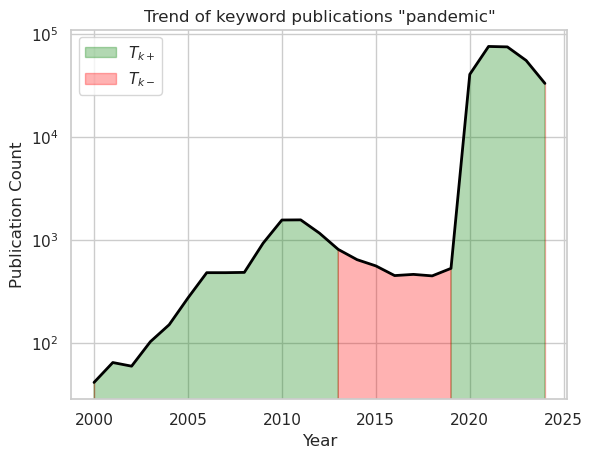

In [5]:
keyword = 'pandemic'
df_keyword = df[df['article_keyword'] == keyword]
df_keyword = df_keyword.sort_values(by='article_publication_year')

# Plot the main trend
sns.lineplot(
    data=df_keyword, 
    x='article_publication_year', 
    y='publication_count', 
    errorbar=None, 
    color='black', 
    linewidth=2
)

# Add shaded areas for positive and negative trends
plt.fill_between(
    df_keyword['article_publication_year'], 
    df_keyword['publication_count'], 
    where=df_keyword['is_trend_positive'],
    interpolate=True, 
    color='green', 
    alpha=0.3, 
    label='$T_{k+}$'
)

plt.fill_between(
    df_keyword['article_publication_year'], 
    df_keyword['publication_count'], 
    where=~df_keyword['is_trend_positive'],
    interpolate=True, 
    color='red', 
    alpha=0.3, 
    label='$T_{k-}$'
)

# Add title and labels
plt.title(f'Trend of keyword publications "{keyword}"')
plt.xlabel('Year')
plt.ylabel('Publication Count')
plt.yscale('log')

# Add legend
plt.legend()

# Show the plot
plt.show()

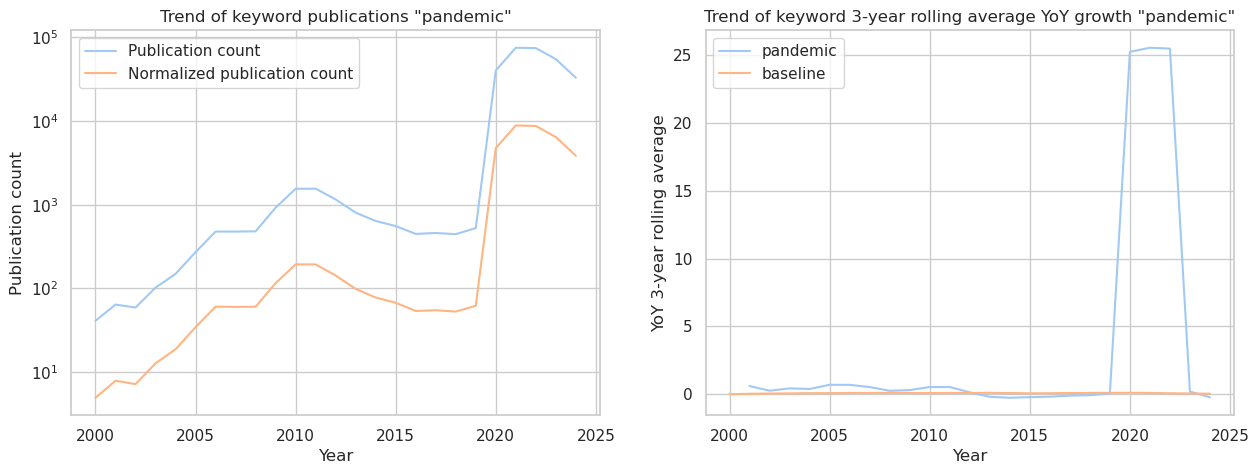

In [6]:
# Visualize the trend of the keyword
df_keyword = df_keyword.sort_values(by='article_publication_year')

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.lineplot(data=df_keyword, x='article_publication_year', y='publication_count', errorbar=None, ax=axs[0])
sns.lineplot(data=df_keyword, x='article_publication_year', y='publication_normalized_count', errorbar=None, ax=axs[0])
axs[0].set_title(f'Trend of keyword publications "{keyword}"')
axs[0].set_xlabel('Year')
axs[0].set_ylabel('Publication count')
axs[0].legend(['Publication count', 'Normalized publication count'])
axs[0].set_yscale('log')

sns.lineplot(data=df_keyword, x='article_publication_year', y='publication_count_yoy_3yr_rolling_avg', errorbar=None, ax=axs[1])
sns.lineplot(data=df_keyword, x='article_publication_year', y='publication_count_yoy_3yr_rolling_avg_baseline', errorbar=None,
             ax=axs[1])
axs[1].set_title(f'Trend of keyword 3-year rolling average YoY growth "{keyword}"')
axs[1].set_xlabel('Year')
axs[1].set_ylabel('YoY 3-year rolling average')
axs[1].legend([keyword, 'baseline'])
plt.show()

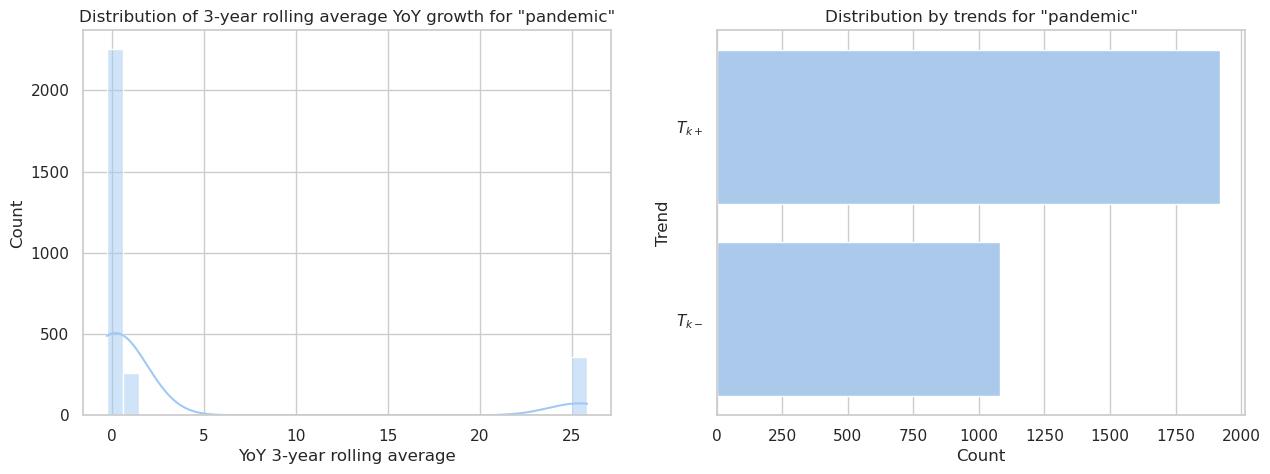

In [7]:
# Visualize the distribution of the positive versus negative trends
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
sns.histplot(data=df_keyword, x='publication_count_yoy_3yr_rolling_avg', bins=30, kde=True, ax=axs[0])
axs[0].set_title(f'Distribution of 3-year rolling average YoY growth for "{keyword}"')
axs[0].set_xlabel('YoY 3-year rolling average')

# Visualize barplot of the positive versus negative trends counting the number of occurrences of distinct keywords, years and research areas
df_keyword['unique_id'] = list(
    map(lambda x, y, z: f'{x}_{y}_{z}', df_keyword['article_publication_year'], df_keyword['article_keyword'],
        df_keyword['research_area_code']))

df_keyword['positive_trend'] = df_keyword['is_trend_positive'].apply(lambda x: '$T_{k+}$' if x else '$T_{k-}$')
df_keyword['positive_trend'] = df_keyword['positive_trend'].astype('category')

sns.countplot(data=df_keyword, y='positive_trend', ax=axs[1], orient='h',
              order=df_keyword['positive_trend'].value_counts().index)
axs[1].set_title(f'Distribution by trends for "{keyword}"')
axs[1].set_xlabel('Count')
axs[1].set_ylabel('Trend')
plt.show()

## Testing research trend impact on collaboration novelty

We assume a statistically significant difference between the popularities of new and existing collaborations, where collaborations in trending research areas should have significantly more new collaborations versus areas that are not trending or are even in a declining trend. We will build a logistic regression model to determine the impact that the popularity has on collaboration novelty. We assume the $\beta$ coefficient will be strictly positive, if there exists a positive correlation between collaboration novelty and keyword popularity.

**NULL HYPOTHESIS** $\beta <= 0$

In [8]:
# Sample the data so that we'll have a balanced dataset over collabroation types
n_new_collaborations = df_popularity['is_new_collaboration'].sum()
n_existing_collaborations = df_popularity.shape[0] - n_new_collaborations
min_collaboration_count = min(n_new_collaborations, n_existing_collaborations)
print(f'Number of new collaborations: {n_new_collaborations}')
print(f'Number of existing collaborations: {n_existing_collaborations}')

Number of new collaborations: 288316
Number of existing collaborations: 27323


In [9]:
df_popularity_positive = df_popularity[df_popularity['is_new_collaboration'] == 1].sample(n=min_collaboration_count)
df_popularity_negative = df_popularity[df_popularity['is_new_collaboration'] == 0].sample(n=min_collaboration_count)
df_popularity_sampled = pd.concat([df_popularity_positive, df_popularity_negative])

popularity_percentile_2_5 = df_popularity_sampled['keyword_popularity_index'].quantile(0.025)
popularity_percentile_97_5 = df_popularity_sampled['keyword_popularity_index'].quantile(0.975)
df_popularity_sampled = df_popularity_sampled[
    (df_popularity_sampled['keyword_popularity_index'] > popularity_percentile_2_5) & 
    (df_popularity_sampled['keyword_popularity_index'] < popularity_percentile_97_5)
]
df_popularity_sampled["keyword_popularity_index_std"] = (df_popularity_sampled["keyword_popularity_index"] - df_popularity_sampled["keyword_popularity_index"].mean()) / df_popularity_sampled["keyword_popularity_index"].std()
df_popularity_sampled.head(5)

,article_id,collaboration_type,keyword_popularity,keyword_popularity_index,is_new_collaboration,keyword_popularity_index_std
123812,84924804304,new,0,0.020611,1,-0.050181
11272,2-s2.0-34347286405,new,0,-0.074437,1,-0.964313
177095,85044157437,new,1,0.046910,1,0.202744
244327,85105242365,new,0,-0.014249,1,-0.385448
109338,84893841330,new,1,0.029521,1,0.035505


In [10]:
print(df_popularity_sampled['is_new_collaboration'].value_counts())
print(df_popularity_sampled['keyword_popularity'].value_counts())

is_new_collaboration
0    26099
1    25713
Name: count, dtype: int64
keyword_popularity
0    21444
1    18748
2     8471
3     2543
4      557
5       49
Name: count, dtype: int64


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 151 seconds.


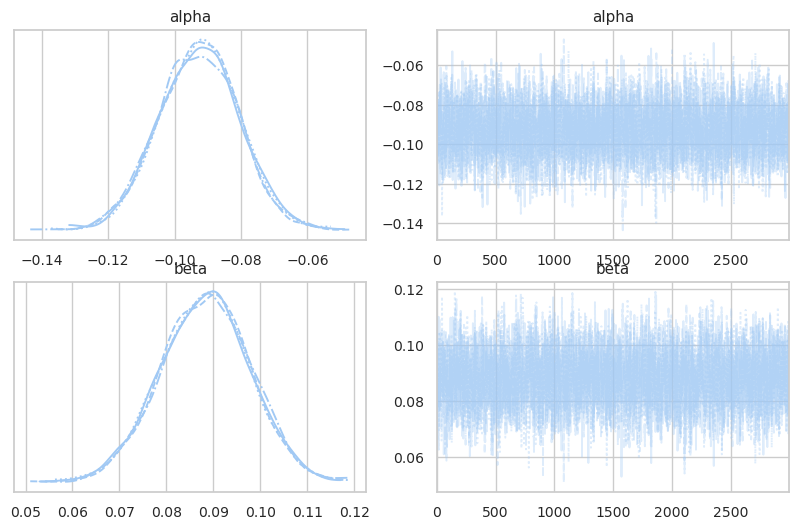

In [11]:
with pm.Model() as model:
    # Priors on intercept and slope
    alpha = pm.Cauchy("alpha", alpha=0, beta=2.5)
    beta = pm.Cauchy("beta", alpha=0, beta=2.5)

    # Linear predictor
    mu = alpha + beta * df_popularity_sampled["keyword_popularity"].values

    # Convert to probability via the logistic function
    p = pm.Deterministic("p", pm.math.sigmoid(mu))

    # Observed data
    y_obs = pm.Bernoulli("y_obs", p=p, observed=df_popularity_sampled["is_new_collaboration"].values)

    # Sample from the posterior
    trace = pm.sample(
        draws=3000,  # post-warmup draws
        tune=1000,  # warmup (tuning) draws
        target_accept=0.9,
        random_seed=42,
        progressbar=True
    )
    
# Plot the trace and posterior distributions for alpha, beta
az.plot_trace(trace, var_names=["alpha", "beta"], figsize=(10, 6))
plt.show()

In [12]:
# Summary of posterior
az.summary(trace, var_names=["alpha", "beta"], hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-0.093,0.012,-0.116,-0.069,0.0,0.0,3938.0,5763.0,1.0
beta,0.088,0.009,0.069,0.106,0.0,0.0,3674.0,5437.0,1.0


## Keyword popularity distributions

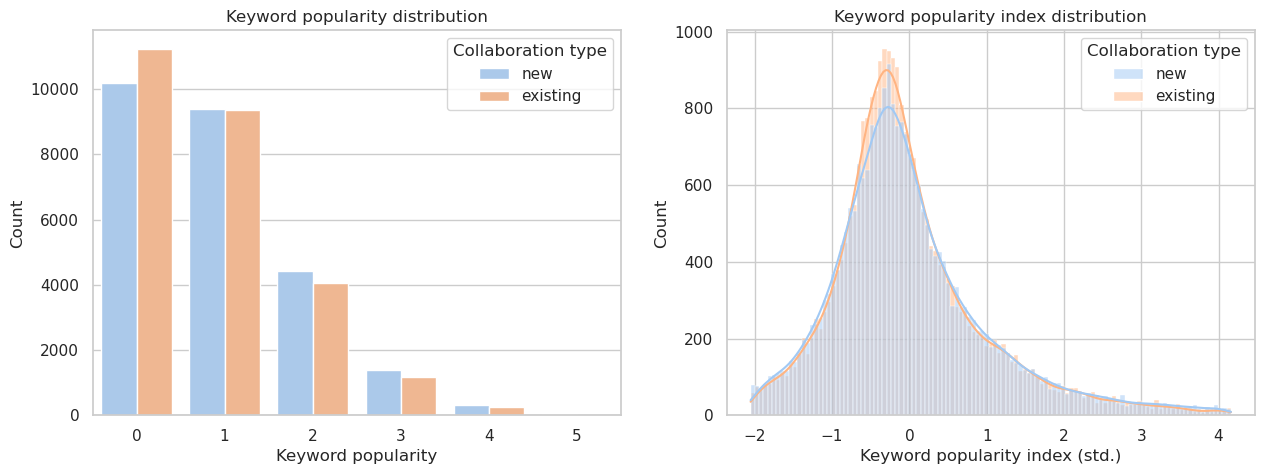

In [23]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

df_popularity_sampled_plot = df_popularity_sampled.copy()
df_popularity_sampled_plot['Collaboration type'] = df_popularity_sampled_plot['collaboration_type']
# Determine the unique collaboration types in the order they should appear
collaboration_order = df_popularity_sampled_plot['Collaboration type'].unique()

# Distribution of keyword popularity
sns.countplot(data=df_popularity_sampled_plot, 
              x="keyword_popularity",
              hue='Collaboration type',
              hue_order=collaboration_order,
              ax=axs[0])
axs[0].set_title("Keyword popularity distribution")
axs[0].set_xlabel("Keyword popularity")
axs[0].set_ylabel("Count")


# Distribution of keyword popularity index
sns.histplot(data=df_popularity_sampled_plot, 
             x='keyword_popularity_index_std',
             kde=True,
             hue='Collaboration type',
             hue_order=collaboration_order,
             ax=axs[1])
axs[1].set_title("Keyword popularity index distribution")
axs[1].set_xlabel("Keyword popularity index (std.)")
plt.savefig('../assets/report_figures/factors_research_trends_results.png')
plt.show()

### Distribution tail examples

In [14]:
# All articles related to COVID
df_popularity[df_popularity['collaboration_type'] == 'new'].sort_values(by='keyword_popularity_index', ascending=False).head(10)

,article_id,collaboration_type,keyword_popularity,keyword_popularity_index,is_new_collaboration
232721,85095717189,new,5,260.107247,1
277921,85138748804,new,5,257.373409,1
36791,2-s2.0-85142233442,new,3,255.683549,1
258769,85119500887,new,4,250.542451,1
220734,85084845206,new,3,250.206834,1
33801,2-s2.0-85098148068,new,3,250.111066,1
232324,85094938750,new,5,248.124403,1
238146,85100315965,new,2,241.747401,1
222737,85086432387,new,4,240.838945,1
243802,85104886048,new,3,234.296736,1


In [15]:
sql_query = """
SELECT a.article_title,
       a.article_eid,
       a.article_doi,
       a.article_publication_dt,
       ak.article_keyword
FROM analitik.dim_article a
         INNER JOIN analitik.fct_article_keyword ak
                    ON a.article_id = ak.article_id
WHERE a.article_id IN ('85095717189', '85138748804');
"""

df_example = query(conn=pg_connection, query_str=sql_query)
df_example.head(10)

,article_title,article_eid,article_doi,article_publication_dt,article_keyword
0,India’s lockdown: an interim report,2-s2.0-85095717189,10.1007/s41775-020-00094-2,2020-11-01,covid-19
1,India’s lockdown: an interim report,2-s2.0-85095717189,10.1007/s41775-020-00094-2,2020-11-01,pandemic
2,India’s lockdown: an interim report,2-s2.0-85095717189,10.1007/s41775-020-00094-2,2020-11-01,lockdown
3,India’s lockdown: an interim report,2-s2.0-85095717189,10.1007/s41775-020-00094-2,2020-11-01,healthcare
4,India’s lockdown: an interim report,2-s2.0-85095717189,10.1007/s41775-020-00094-2,2020-11-01,vulnerability
5,Clinical Progression and Outcome of Hospitaliz...,2-s2.0-85138748804,10.3390/vaccines10091409,2022-09-01,covid
6,Clinical Progression and Outcome of Hospitaliz...,2-s2.0-85138748804,10.3390/vaccines10091409,2022-09-01,sars-cov-2
7,Clinical Progression and Outcome of Hospitaliz...,2-s2.0-85138748804,10.3390/vaccines10091409,2022-09-01,hospitalization
8,Clinical Progression and Outcome of Hospitaliz...,2-s2.0-85138748804,10.3390/vaccines10091409,2022-09-01,vaccination
9,Clinical Progression and Outcome of Hospitaliz...,2-s2.0-85138748804,10.3390/vaccines10091409,2022-09-01,china


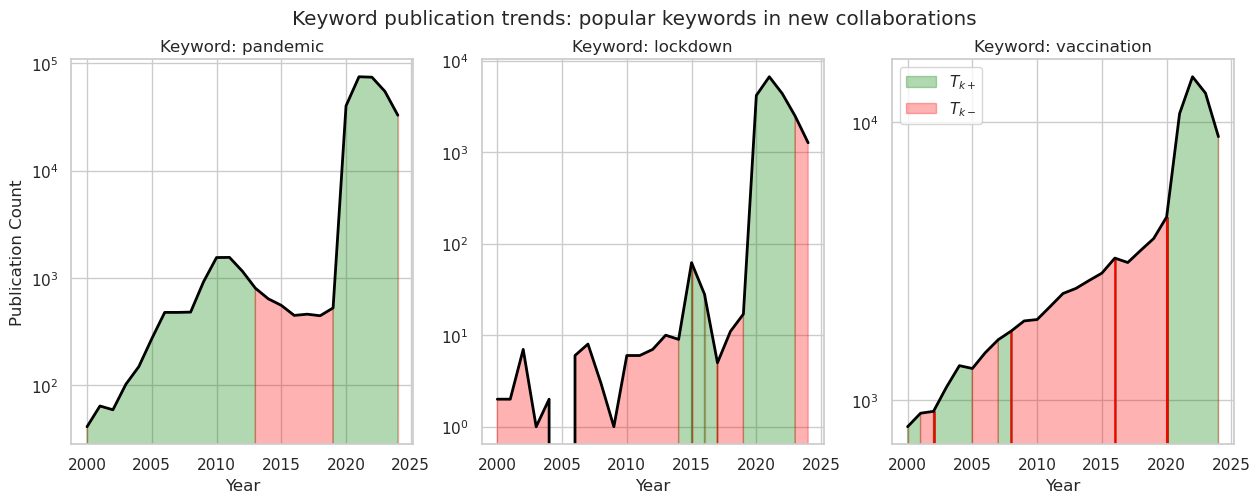

In [24]:
fig, axs = plt.subplots(ncols=3, figsize=(15, 5))

for ix, keyword in enumerate(['pandemic', 'lockdown', 'vaccination']):
    df_keyword = df[df['article_keyword'] == keyword]
    df_keyword = df_keyword.sort_values(by='article_publication_year')
    
    
    # Plot the main trend
    sns.lineplot(
        data=df_keyword, 
        x='article_publication_year', 
        y='publication_count', 
        errorbar=None, 
        color='black', 
        linewidth=2,
        ax=axs[ix]
    )
    
    # Handle smooth transitions for fill_between
    years = df_keyword['article_publication_year']
    counts = df_keyword['publication_count']
    trend_positive = df_keyword['is_trend_positive']
    
    # Define masks
    pos_mask = trend_positive
    neg_mask = ~trend_positive
    
    # Ensure there's no abrupt cutoff by replacing NaNs with previous values
    pos_mask = np.where(pos_mask, True, False)
    neg_mask = np.where(neg_mask, True, False)

    # Add shaded areas for positive and negative trends
    axs[ix].fill_between(years, counts, where=pos_mask, interpolate=True, color='green', alpha=0.3, label='$T_{k+}$')
    axs[ix].fill_between(years, counts, where=neg_mask, interpolate=True, color='red', alpha=0.3, label='$T_{k-}$')
    
    if ix == 0:
        axs[ix].set_ylabel('Publication Count')
    else:
        axs[ix].set_ylabel('')
    axs[ix].set_xlabel('Year')
    axs[ix].set_title(f'Keyword: {keyword}')
    axs[ix].set_yscale('log')
    
plt.suptitle('Keyword publication trends: popular keywords in new collaborations')
plt.legend()
plt.savefig('../assets/report_figures/factors_research_trends_positive_example.png')
plt.show()

In [17]:
df_popularity[df_popularity['collaboration_type'] == 'existing'].sort_values(by='keyword_popularity_index', ascending=True).head(10)

,article_id,collaboration_type,keyword_popularity,keyword_popularity_index,is_new_collaboration
138441,84956594465,existing,0,-1.366983,0
197533,85063639450,existing,0,-1.189204,0
254063,85114939699,existing,1,-1.109443,0
85319,84864389156,existing,1,-1.107681,0
216573,85081205844,existing,0,-1.106853,0
72723,80051745498,existing,0,-1.092117,0
96620,84877601876,existing,0,-1.085874,0
206460,85072213119,existing,0,-1.055614,0
194623,85061055853,existing,1,-1.030782,0
250200,85111036410,existing,2,-1.028048,0


In [18]:
sql_query = """
SELECT a.article_title,
       a.article_eid,
       a.article_doi,
       a.article_publication_dt,
       ak.article_keyword
FROM analitik.dim_article a
         INNER JOIN analitik.fct_article_keyword ak
                    ON a.article_id = ak.article_id
WHERE a.article_id IN ('85081205844', '84877601876', '85061055853', '85111036410');
"""

df_example = query(conn=pg_connection, query_str=sql_query)
df_example.head(20)

,article_title,article_eid,article_doi,article_publication_dt,article_keyword
0,Moral Dilemmas and Vagueness,2-s2.0-84877601876,10.1007/s12136-011-0140-2,2013-06-01,moral dilemmas
1,Moral Dilemmas and Vagueness,2-s2.0-84877601876,10.1007/s12136-011-0140-2,2013-06-01,vagueness
2,Moral Dilemmas and Vagueness,2-s2.0-84877601876,10.1007/s12136-011-0140-2,2013-06-01,transvaluationism
3,Moral Dilemmas and Vagueness,2-s2.0-84877601876,10.1007/s12136-011-0140-2,2013-06-01,moral pluralism
4,Moral Dilemmas and Vagueness,2-s2.0-84877601876,10.1007/s12136-011-0140-2,2013-06-01,conflict vagueness
5,Theodor Kravina von Kronstein and His Outline ...,2-s2.0-85081205844,n/a,2019-01-01,economic knowledge
6,Theodor Kravina von Kronstein and His Outline ...,2-s2.0-85081205844,n/a,2019-01-01,thesesian academy
7,Theodor Kravina von Kronstein and His Outline ...,2-s2.0-85081205844,n/a,2019-01-01,cameralism
8,Theodor Kravina von Kronstein and His Outline ...,2-s2.0-85081205844,n/a,2019-01-01,physiocracy
9,Theodor Kravina von Kronstein and His Outline ...,2-s2.0-85081205844,n/a,2019-01-01,agriclture


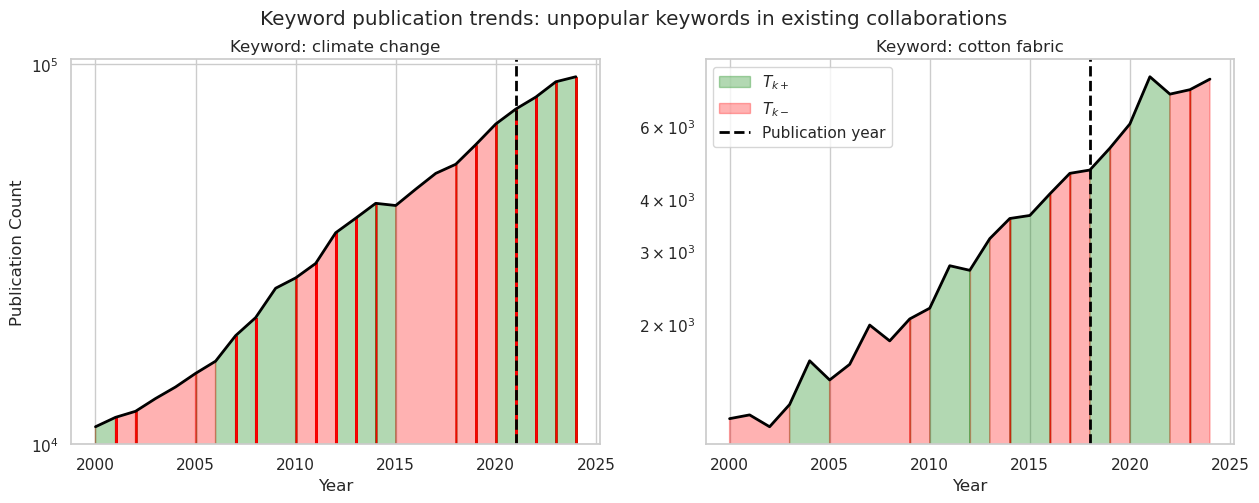

In [25]:
fig, axs = plt.subplots(ncols=2, figsize=(15, 5))

for ix, (keyword, publication_year) in enumerate(zip(['climate change', 'cotton fabric'], [2021, 2018])):
    df_keyword = df[df['article_keyword'] == keyword]
    df_keyword = df_keyword.sort_values(by='article_publication_year')
    
    
    # Plot the main trend
    sns.lineplot(
        data=df_keyword, 
        x='article_publication_year', 
        y='publication_count', 
        errorbar=None, 
        color='black', 
        linewidth=2,
        ax=axs[ix]
    )
    
    # Handle smooth transitions for fill_between
    years = df_keyword['article_publication_year']
    counts = df_keyword['publication_count']
    trend_positive = df_keyword['is_trend_positive']
    
    # Define masks
    pos_mask = trend_positive
    neg_mask = ~trend_positive
    
    # Ensure there's no abrupt cutoff by replacing NaNs with previous values
    pos_mask = np.where(pos_mask, True, False)
    neg_mask = np.where(neg_mask, True, False)

    # Add shaded areas for positive and negative trends
    axs[ix].fill_between(years, counts, where=pos_mask, interpolate=True, color='green', alpha=0.3, label='$T_{k+}$')
    axs[ix].fill_between(years, counts, where=neg_mask, interpolate=True, color='red', alpha=0.3, label='$T_{k-}$')
    axs[ix].axvline(publication_year, linestyle='--', color='black', linewidth=2, label = 'Publication year')
    if ix == 0:
        axs[ix].set_ylabel('Publication Count')
    else:
        axs[ix].set_ylabel('')
    axs[ix].set_xlabel('Year')
    axs[ix].set_title(f'Keyword: {keyword}')
    axs[ix].set_yscale('log')
    
plt.suptitle('Keyword publication trends: unpopular keywords in existing collaborations')
plt.legend()
plt.savefig('../assets/report_figures/factors_research_trends_negative_example.png')
plt.show()